# Box Office Mojo Modeller

In [1]:
%pylab inline
#% config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats
sns.set()


from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf 

import matplotlib.pyplot as plt
%matplotlib inline

/Users/kibbles/anaconda3/envs/metis/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


## Diagnostic_plot function for later

In [2]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

# Import pickled box office data
Very important to take '\_cleaned.pkl' data

In [3]:
path=('./data/mojo_all_years_movies_cleaned.pkl')

In [4]:
df = pd.read_pickle(path)

## Drop films with DTG < \$ 1 mil

count    15973.000000
mean        13.537541
std          3.228295
min          4.276666
25%         10.848482
50%         13.451091
75%         16.468416
max         20.657833
Name: Log_DTG, dtype: float64


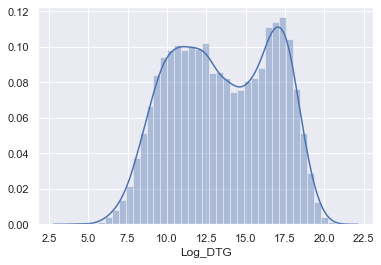

In [5]:
# Examine the current distribution
print(df.Log_DTG.describe())
sns.distplot(df['Log_DTG'])

10.309245424763985


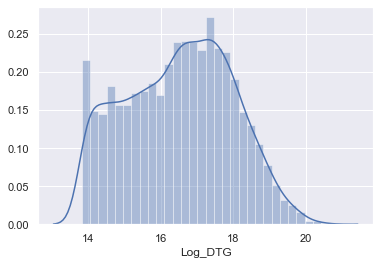

In [6]:
lower_DTG_bound = 1e6
dtg_mean = df.Log_DTG.mean()
dtg_std  = df.Log_DTG.std()
print(dtg_mean - (1*dtg_std))

sns.distplot(df[df.Log_DTG > np.log(lower_DTG_bound) ]['Log_DTG'])

df = df[df.Log_DTG > np.log(lower_DTG_bound) ]

## Drop films with Budget < \$ 1 mil

count    3069.000000
mean       17.212320
std         1.138798
min         9.615805
25%        16.588099
50%        17.312018
75%        17.989898
max        19.690441
Name: Log_Bud, dtype: float64


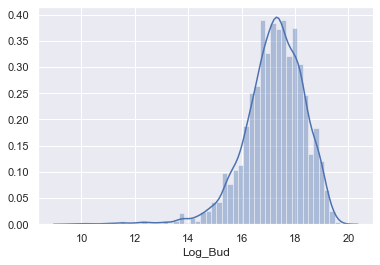

In [7]:
print(df.Log_Bud.describe())
sns.distplot(df['Log_Bud'])

16.073521447100294


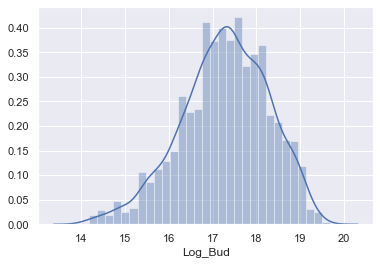

In [8]:
lower_bud_bound = 1e6
bud_mean = df.Log_Bud.mean()
bud_std  = df.Log_Bud.std()
print(bud_mean - (1*bud_std))

sns.distplot(df[df.Log_Bud > np.log(lower_bud_bound) ]['Log_Bud'])

df = df[df.Log_Bud > np.log(lower_bud_bound) ]

## Examine again

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3026 entries, 1 to 15967
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Movie_Title                 3026 non-null   object        
 1   Domestic_Distributor        3017 non-null   object        
 2   Domestic_Total_Gross        3026 non-null   int64         
 3   Runtime                     2979 non-null   float64       
 4   Rating                      2847 non-null   object        
 5   Release_Date                3026 non-null   datetime64[ns]
 6   Budget                      3026 non-null   float64       
 7   Cast1                       3026 non-null   object        
 8   Cast2                       3026 non-null   object        
 9   Cast3                       3026 non-null   object        
 10  Cast4                       3024 non-null   object        
 11  Director                    3026 non-null   object     

In [10]:
df.describe()

,Domestic_Total_Gross,Runtime,Budget,Intercept,Profit_percent,G,NC-17,Not Rated,PG,PG-13,...,Writer_Score,Producer_Score,Cinematographer_Score,Domestic_Distributor_Score,Cast1_Score,Cast2_Score,Cast3_Score,Cast4_Score,Log_DTG,Log_Bud
count,3.026000e+03,2979.000000,3.026000e+03,3026.0,3026.000000,3026.000000,3026.000000,3026.0,3026.000000,3026.000000,...,1635.000000,2123.000000,2673.000000,2975.000000,2358.000000,2046.000000,1692.000000,1354.000000,3026.000000,3026.000000
mean,6.767000e+07,109.876804,4.936462e+07,1.0,1.038589,0.008923,0.001322,0.0,0.149042,0.391606,...,16.709417,16.860642,15.987925,16.452136,16.575926,16.305487,16.302982,16.258743,17.405093,17.277004
std,8.229193e+07,19.340502,4.721308e+07,0.0,3.870244,0.094053,0.036340,0.0,0.356188,0.488190,...,1.988747,1.755730,1.904173,1.129595,1.827262,1.925065,2.128830,2.194245,1.229408,0.998422
min,1.008098e+06,63.000000,1.200000e+06,1.0,-0.982722,0.000000,0.000000,0.0,0.000000,0.000000,...,6.408529,6.742881,6.535241,8.216088,6.152733,6.663133,6.470800,4.276666,13.823576,13.997832
25%,1.757046e+07,96.000000,1.700000e+07,1.0,-0.416791,0.000000,0.000000,0.0,0.000000,0.000000,...,16.048104,16.294154,15.274493,16.274655,16.051521,15.640851,15.621299,15.470871,16.681729,16.648724
50%,4.022262e+07,106.000000,3.410000e+07,1.0,0.172962,0.000000,0.000000,0.0,0.000000,0.000000,...,17.187519,17.243649,16.496814,16.830615,17.028238,16.739374,16.847746,16.766672,17.509940,17.344804
75%,8.413296e+07,121.000000,6.500000e+07,1.0,1.201186,0.000000,0.000000,0.0,0.000000,1.000000,...,17.979773,17.956202,17.289197,17.115119,17.699300,17.513911,17.650998,17.738966,18.247909,17.989898
max,9.366622e+08,242.000000,3.560000e+08,1.0,122.365901,1.000000,1.000000,0.0,1.000000,1.000000,...,19.920614,20.092487,19.681999,18.598098,20.657833,20.657833,20.098215,20.657833,20.657833,19.690441


## correlation

In [11]:
df.corr()

,Domestic_Total_Gross,Runtime,Budget,Intercept,Profit_percent,G,NC-17,Not Rated,PG,PG-13,...,Writer_Score,Producer_Score,Cinematographer_Score,Domestic_Distributor_Score,Cast1_Score,Cast2_Score,Cast3_Score,Cast4_Score,Log_DTG,Log_Bud
Domestic_Total_Gross,1.000000,0.265635,0.628968,NaN,0.232015,0.063550,-0.026299,NaN,0.115962,0.129357,...,0.244921,0.270002,0.198640,0.250812,0.128636,0.133145,0.110500,0.093003,0.767202,0.500135
Runtime,0.265635,1.000000,0.310708,NaN,-0.040532,-0.075958,0.031521,NaN,-0.192458,0.085964,...,0.031881,0.044803,0.095851,-0.025149,-0.010482,0.024280,-0.033460,0.005449,0.191744,0.292508
Budget,0.628968,0.310708,1.000000,NaN,-0.180462,0.031539,-0.022632,NaN,0.132865,0.203599,...,0.265441,0.317342,0.276525,0.340837,0.163653,0.114396,0.080171,0.102448,0.556866,0.854876
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profit_percent,0.232015,-0.040532,-0.180462,NaN,1.000000,0.150149,-0.014501,NaN,0.008523,-0.060716,...,0.030935,0.015045,-0.088577,-0.096864,-0.042799,-0.004500,0.008385,0.000408,0.266958,-0.323340
G,0.063550,-0.075958,0.031539,NaN,0.150149,1.000000,-0.003452,NaN,-0.039709,-0.076125,...,0.030061,0.054314,0.062482,0.037145,-0.034505,-0.024880,0.020229,0.028218,0.057310,0.011168
NC-17,-0.026299,0.031521,-0.022632,NaN,-0.014501,-0.003452,1.000000,NaN,-0.015226,-0.029189,...,-0.020176,-0.049921,-0.009652,-0.044928,-0.024237,-0.063138,0.007204,NaN,-0.053455,-0.027459
Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PG,0.115962,-0.192458,0.132865,NaN,0.008523,-0.039709,-0.015226,NaN,1.000000,-0.335762,...,0.080307,0.106068,0.094804,0.141466,0.033238,0.018326,0.097599,0.056166,0.142707,0.135798
PG-13,0.129357,0.085964,0.203599,NaN,-0.060716,-0.076125,-0.029189,NaN,-0.335762,1.000000,...,0.070930,0.090095,0.066093,0.106728,0.085168,0.045588,-0.012888,-0.000944,0.146832,0.193792


# Define subset

In [12]:
subset = (['Log_DTG','Intercept','Log_Bud','Runtime','Domestic_Distributor_Score',
           'Director_Score','Producer_Score'])
#'Cast1_Score','Writer_Score',

In [13]:
features = df[subset]
features = features.dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 1 to 15921
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Log_DTG                     1674 non-null   float64
 1   Intercept                   1674 non-null   int64  
 2   Log_Bud                     1674 non-null   float64
 3   Runtime                     1674 non-null   float64
 4   Domestic_Distributor_Score  1674 non-null   float64
 5   Director_Score              1674 non-null   float64
 6   Producer_Score              1674 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 104.6 KB


## Compare Log Budget to Log DTG

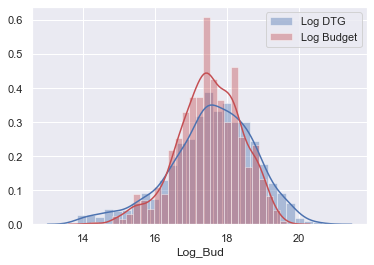

In [14]:
sns.distplot(features['Log_DTG'])
sns.distplot(features['Log_Bud'],color='r')
plt.legend(['Log DTG','Log Budget']);

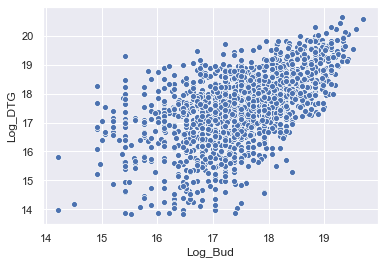

In [15]:
sns.scatterplot(x=features['Log_Bud'], y=features['Log_DTG'], )

## Pairplot of Subset

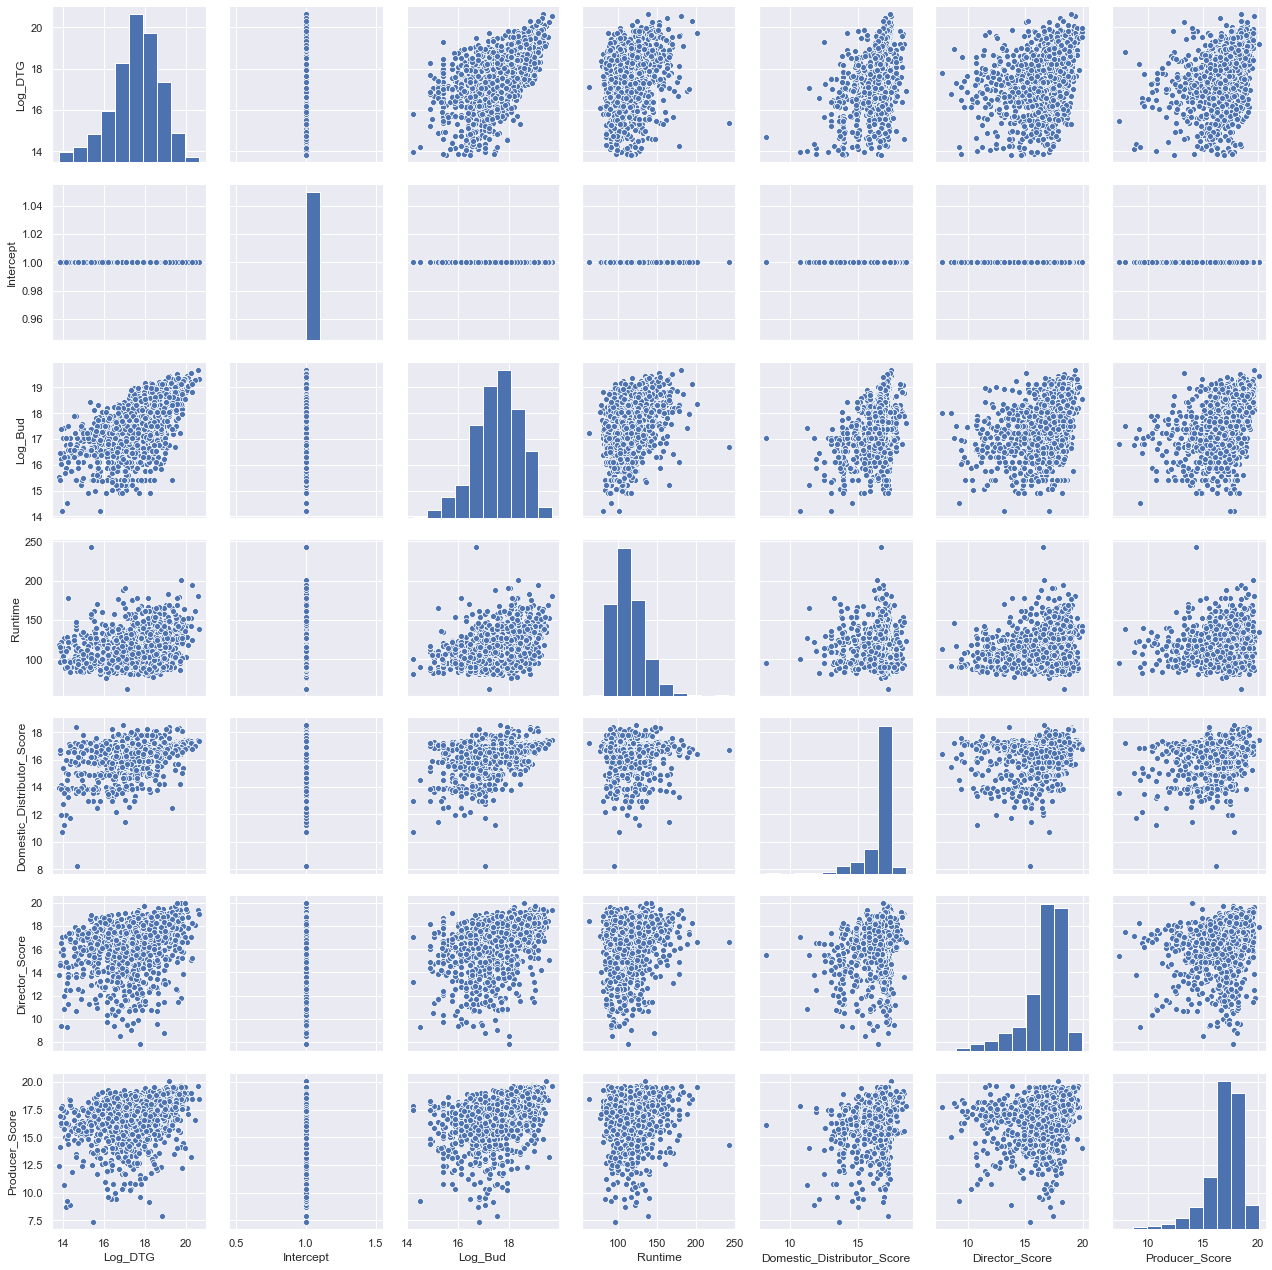

In [16]:
sns.pairplot(features)

# Model init and fitting
___

In [17]:
X = features.loc[:, features.columns != 'Log_DTG']
y = features['Log_DTG']

In [18]:
#Split the data 80 - 20 train/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=30)

(print(#'Training cols: ',X_train.columns,'\n',
       ' Train+Val set dims:   ', X_train_val.shape,'\n',
       'Testing set dims:    ', X_test.shape,'\n',
))

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=30)
(print(#'Training cols: ',X_train.columns,'\n',
       ' Training set dims:   ', X_train.shape,'\n',
       'Validation set dims: ', X_val.shape,'\n',
       'Testing set dims:    ', X_test.shape,'\n',
))


 Train+Val set dims:    (1339, 6) 
 Testing set dims:     (335, 6) 

 Training set dims:    (1004, 6) 
 Validation set dims:  (335, 6) 
 Testing set dims:     (335, 6) 



## statsmodels OLS

In [19]:
# Create your model
statsmodel = sm.OLS(y_train, X_train) #sm.add_constant(scaler.fit_transform(X_train)))

# Fit your model to your training set
stats_fit = statsmodel.fit()

## OLS

In [20]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()
lm.fit(X_train_val, y_train_val)

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.40381095, 0.4297128 , 0.47782644, 0.29927383, 0.22613938])

In [21]:
splits = 5
kf = KFold(n_splits=splits, shuffle=True, random_state = 42)
scoring_dict = {'R2':   'r2',
                'MAE':  'neg_mean_absolute_error',
                'RMSE': 'neg_root_mean_squared_error'
               }
n = len(X_train_val)/splits
p = X_train_val.shape[1]
r2 = np.mean(cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['R2']))
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Cross-Validation scoring for OLS:')
print(f'Linear Regression val Adj_R2: {adj_r2:.3f}')
for score in scoring_dict:
    print('Linear Regression val',score,f': {np.mean(cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring=scoring_dict[score])):.3f}')


Cross-Validation scoring for OLS:
Linear Regression val Adj_R2: 0.362
Linear Regression val R2 : 0.376
Linear Regression val MAE : -0.737
Linear Regression val RMSE : -0.942


## LASSO

In [22]:
## Scale the variables
std = preprocessing.StandardScaler()
std.fit(X_train_val.values)

## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

In [23]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

### LASSO LARS path

In [24]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


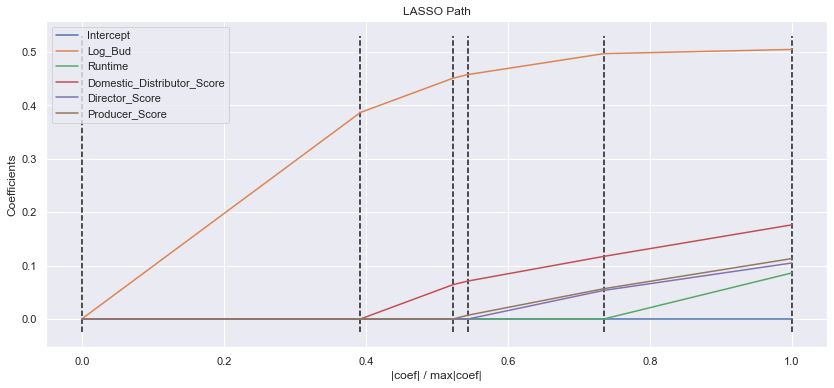

In [25]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(14,6))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|'); plt.ylabel('Coefficients'); plt.title('LASSO Path')
plt.axis('tight'); plt.legend(X_train.columns); plt.show()

## Ridge

In [26]:
# ## Scale the variables
# std = preprocessing.StandardScaler()
# std.fit(X_train_val.values)

# ## Scale the Predictors on both the train and test set
# X_tr = std.transform(X_train_val.values)
# X_te = std.transform(X_test.values)

In [27]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

### Ridge LARS path

In [28]:
## Note: lars_path takes numpy matrices, not pandas dataframes
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train_val.values, method='ridge')

Computing regularization path using the LARS ...


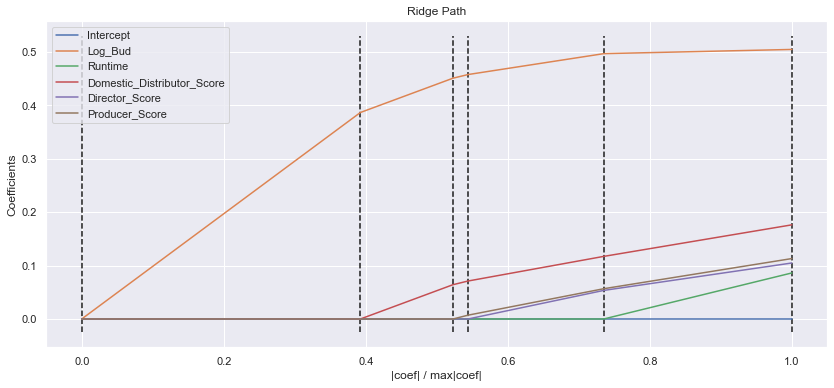

In [29]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(14,6))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|'); plt.ylabel('Coefficients'); plt.title('Ridge Path')
plt.axis('tight'); plt.legend(X_train_val.columns); plt.show()

# Results
___

## Results: Statsmodels OLS

In [30]:
# Print summary statistics of the model's performance
stats_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Log_DTG   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     132.8
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          6.11e-108
Time:                        00:50:01   Log-Likelihood:                -1354.8
No. Observations:                1004   AIC:                             2722.
Df Residuals:                     998   BIC:                             2751.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.9546      0.634      3.082      0.002       0.710       3.199
Log_Bud                        0.5410      0.040     13.559      0.000       0.463       0.619
Runtime                        0.0039      0.002      2.452      0.014       0.001       0.007
Domestic_Distributor_Score     0.2035      0.035      5.769      0.000       0.134       0.273
Director_Score                 0.0548      0.018      3.131      0.002       0.020       0.089
Producer_Score                 0.0840      0.020      4.167      0.000       0.044       0.124
==============================================================================
Omnibus:                       43.441   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.565
Skew:                          -0.472   Prob(JB):                     1.05e-11
Kurtosis:                       3.565   Cond. No.                     2.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Results: LASSO

In [31]:
lasso_model.alpha_

0.01

In [32]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, lasso_model.coef_))

[('Intercept', 0.0),
 ('Log_Bud', 0.5042382780855776),
 ('Runtime', 0.0779485914112222),
 ('Domestic_Distributor_Score', 0.17068030181985153),
 ('Director_Score', 0.09995278639514896),
 ('Producer_Score', 0.10775935765676482)]

In [33]:
# Make predictions on the test set using the new model
lasso_test_set_pred = lasso_model.predict(X_te)

In [34]:
lasso_r2 = r2_score(y_test, lasso_test_set_pred)
print(lasso_r2)

0.42230480044542473


In [35]:
n = len(X_test)
p = X_test.shape[1]
lasso_adj_r2 = 1-(1-lasso_r2)*(n-1)/(n-p-1)
print(lasso_adj_r2)

0.4117372053316215


In [36]:
lasso_mae = np.abs(np.exp(y_test) - np.exp(lasso_test_set_pred)).sum() / len(X_test)
(lasso_mae)

40011475.81178484

In [37]:
lasso_rmse = np.sqrt( ((np.exp(y_test) - np.exp(lasso_test_set_pred))**2).sum() ) / len(X_test)
lasso_rmse

3827751.3678857484

In [38]:
lasso_results = {'R2': lasso_r2,
               'Adj R2': lasso_adj_r2,
               'MAE': lasso_mae,
               'RMSE': lasso_rmse,
              }

## Results: Ridge

In [39]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
ridge_model.alpha_

27.36439997074672

In [40]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, ridge_model.coef_))

[('Intercept', 0.0),
 ('Log_Bud', 0.4929371494141284),
 ('Runtime', 0.08823623948735478),
 ('Domestic_Distributor_Score', 0.17651280764400468),
 ('Director_Score', 0.10665475607940612),
 ('Producer_Score', 0.11482629358034895)]

In [41]:
# Make predictions on the test set using the new model
ridge_test_set_pred = ridge_model.predict(X_te)

In [42]:
ridge_r2 = r2_score(y_test, ridge_test_set_pred)
print(ridge_r2)

0.4228960386062187


In [43]:
n = len(X_test)
p = X_test.shape[1]
ridge_adj_r2 = 1-(1-ridge_r2)*(n-1)/(n-p-1)
print(ridge_adj_r2)

0.4123392588246251


In [44]:
ridge_mae = np.abs(np.exp(y_test) - np.exp(ridge_test_set_pred)).sum() / len(X_test)
(ridge_mae)

39976890.05819928

In [45]:
ridge_rmse = np.sqrt( ((np.exp(y_test) - np.exp(ridge_test_set_pred))**2).sum() ) / len(X_test)
ridge_rmse

3826341.416418944

In [46]:
ridge_results = {'R2': ridge_r2,
               'Adj R2': ridge_adj_r2,
               'MAE': ridge_mae,
               'RMSE': ridge_rmse,
              }

## Results: OLS

In [47]:
ols_test_set_pred = lm.predict(X_test)

In [48]:
ols_r2 = r2_score(y_test, ols_test_set_pred)
print(ols_r2)

0.4240944776707256


In [49]:
n = len(X_test)
p = X_test.shape[1]
ols_adj_r2 = 1-(1-ols_r2)*(n-1)/(n-p-1)
(ols_adj_r2)

0.4135596205549462

In [50]:
ols_mae = np.abs(np.exp(y_test) - np.exp(ols_test_set_pred)).sum() / len(X_test)
(ols_mae)

39883942.759199485

In [51]:
ols_rmse = np.sqrt( ((np.exp(y_test) - np.exp(ols_test_set_pred))**2).sum() ) / len(X_test)
ols_rmse

3808216.651246518

In [52]:
ols_results = {'R2': ols_r2,
               'Adj R2': ols_adj_r2,
               'MAE': ols_mae,
               'RMSE': ols_rmse,
              }

## Results for all!

In [53]:
results_models = ['OLS', 'LASSO', 'Ridge']
results_cols = ['R2','Adj R2','MAE','RMSE']
results_df = pd.DataFrame(index = results_models, columns = results_cols)
results_df.loc['OLS'] = ols_results
results_df.loc['Ridge'] = ridge_results
results_df.loc['LASSO'] = lasso_results
results_df

,R2,Adj R2,MAE,RMSE
OLS,0.424094,0.41356,3.98839e+07,3.80822e+06
LASSO,0.422305,0.411737,4.00115e+07,3.82775e+06
Ridge,0.422896,0.412339,3.99769e+07,3.82634e+06


# Test result plots

## Statsmodel residuals

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Statsmodels Residuals')

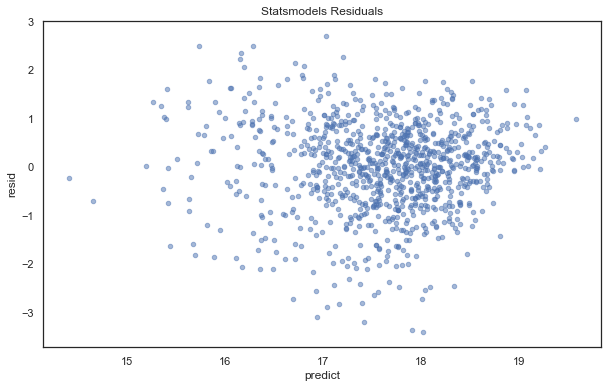

In [54]:
# create residual plot
residuals = pd.DataFrame()
residuals['predict']=stats_fit.predict(X_train)
residuals['resid']= y_train-residuals.predict
with sns.axes_style('white'):
    plot = residuals.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6));
plt.title('Statsmodels Residuals')

## Predicted-Observed Test Results

In [55]:
models = {'OLS': lm, 'LASSO': lasso_model, 'Ridge': ridge_model}

### OLS Predicted-Observed Test Results

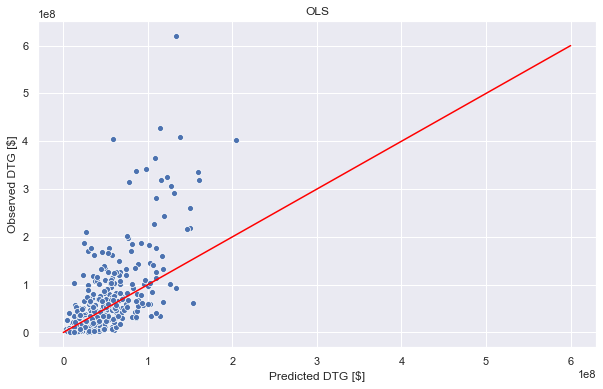

In [56]:
model = 'OLS'

plt.figure(figsize=(10,6))
sns.scatterplot(x=np.exp(models[model].predict(X_test)), y=np.exp(y_test))
plt.xlabel('Predicted DTG [$]'); plt.ylabel('Observed DTG [$]'); plt.title(model)
plt.plot((0,6e8), (0,6e8), c='red');

### LASSO Predicted-Observed Test Results

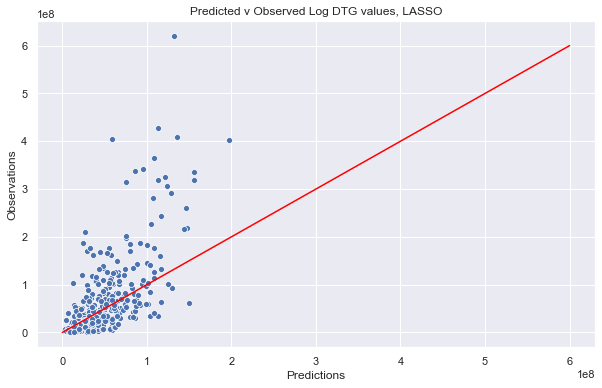

In [57]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=np.exp(y_test), x=np.exp(lasso_test_set_pred));
plt.xlabel('Predictions'); plt.ylabel('Observations'); plt.title('Predicted v Observed Log DTG values, LASSO');
plt.plot((0,6e8), (0,6e8), c='red');

### Ridge Predicted-Observed Test Results

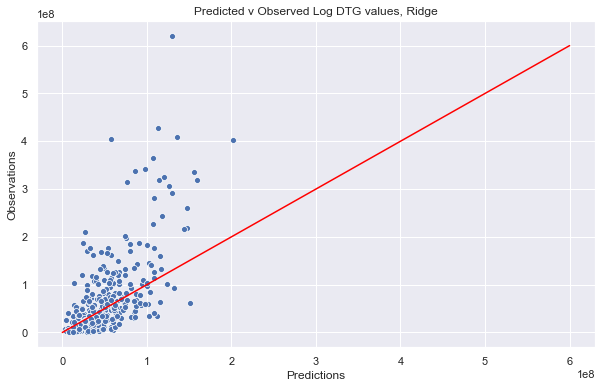

In [58]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=np.exp(y_test), x=np.exp(ridge_test_set_pred));
plt.xlabel('Predictions'); plt.ylabel('Observations'); plt.title('Predicted v Observed Log DTG values, Ridge');
plt.plot((0,6e8), (0,6e8), c='red');

## OLS, LASSO, Ridge QQ plots

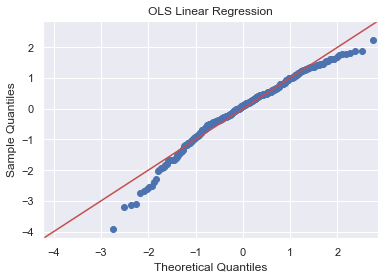

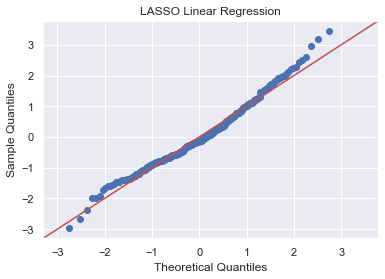

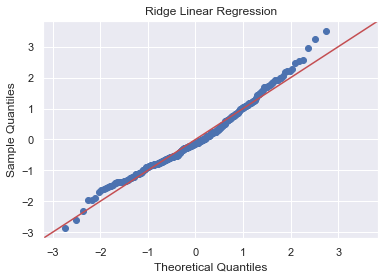

In [59]:
# Prediction vs Reality.
import pylab as py

models = {'OLS': lm, 'LASSO': lasso_model, 'Ridge': ridge_model}
for model in models:
    sm.qqplot(models[model].predict(X_test), line='45', fit=True)
    plt.title(model+' Linear Regression')
    #py.show()